In [1]:
%%capture
!pip install kagglehub pandas scikit-learn xgboost numpy time matplotlib

In [2]:
import kagglehub
import pandas as pd
import os

# Download latest version
path = kagglehub.dataset_download("icarofreire/best-filter-and-featureengineering")

# Загружаем данные 
train = pd.read_csv(os.path.join(path, 'final_train1.csv'))  # обучающая выборка
test = pd.read_csv(os.path.join(path, 'final_test1.csv'))    # тестовая выборка

print("Path to dataset files:", path)

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

train.head(), test.head()


Path to dataset files: /home/krig/.cache/kagglehub/datasets/icarofreire/best-filter-and-featureengineering/versions/1
Train shape: (5000000, 80)
Test shape: (2000000, 79)


(   open_channels  signal  lag_t1  lag_t2  lag_t3  lead_t1  lead_t2  lead_t3  \
 0            0.0  -2.760   0.000   0.000   0.000   -2.848   -2.424   -3.130   
 1            0.0  -2.848  -2.760   0.000   0.000   -2.424   -3.130   -3.145   
 2            0.0  -2.424  -2.848  -2.760   0.000   -3.130   -3.145   -2.650   
 3            0.0  -3.130  -2.424  -2.848  -2.760   -3.145   -2.650   -2.697   
 4            0.0  -3.145  -3.130  -2.424  -2.848   -2.650   -2.697   -2.596   
 
    signalmean_t1000  signalstd_t1000  ...  signalvar_t80000  signalmin_t80000  \
 0               0.0              0.0  ...               0.0               0.0   
 1               0.0              0.0  ...               0.0               0.0   
 2               0.0              0.0  ...               0.0               0.0   
 3               0.0              0.0  ...               0.0               0.0   
 4               0.0              0.0  ...               0.0               0.0   
 
    signalmax_t80000  no

# Data preparation

In [3]:
from sklearn.preprocessing import StandardScaler

# Проверяем пропуски
print("Train missing values:\n", train.isnull().sum().sum())
print("Test missing values:\n", test.isnull().sum().sum())

# Убираем дубликаты
train = train.drop_duplicates()

# Масштабируем данные
scaler = StandardScaler()

# Выбираем признаки для обучения (всё кроме целевой переменной open_channels)
X = train.drop(columns=['open_channels'])
y = train['open_channels']

X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
test_scaled = pd.DataFrame(scaler.transform(test), columns=test.columns)

X_scaled.head()


Train missing values:
 0
Test missing values:
 0


,signal,lag_t1,lag_t2,lag_t3,lead_t1,lead_t2,lead_t3,signalmean_t1000,signalstd_t1000,signalvar_t1000,...,signalvar_t80000,signalmin_t80000,signalmax_t80000,norm_t80000,signalmean_t80000_lead,signalstd_t80000_lead,signalvar_t80000_lead,signalmin_t80000_lead,signalmax_t80000_lead,norm_t80000_lead
0,-1.144837,-0.033271,-0.033270,-0.033270,-1.180280,-1.009519,-1.293857,-0.036793,-1.81662,-1.074956,...,-0.956286,2.159584,-0.762387,-1.047032,-0.032745,-1.073794,-0.795451,1.410688,-0.653439,-0.857925
1,-1.180279,-1.144838,-0.033270,-0.033270,-1.009517,-1.293855,-1.299898,-0.036793,-1.81662,-1.074956,...,-0.956286,2.159584,-0.762387,-1.047032,-0.032745,-1.073794,-0.795451,1.410688,-0.653439,-0.857925
2,-1.009516,-1.180280,-1.144839,-0.033270,-1.293854,-1.299897,-1.100540,-0.036793,-1.81662,-1.074956,...,-0.956286,2.159584,-0.762387,-1.047032,-0.032745,-1.073794,-0.795451,1.410688,-0.653439,-0.857925
3,-1.293852,-1.009517,-1.180281,-1.144840,-1.299895,-1.100539,-1.119469,-0.036793,-1.81662,-1.074956,...,-0.956286,2.159584,-0.762387,-1.047032,-0.032745,-1.073794,-0.795451,1.410688,-0.653439,-0.857925
4,-1.299893,-1.293853,-1.009518,-1.180281,-1.100537,-1.119468,-1.078792,-0.036793,-1.81662,-1.074956,...,-0.956286,2.159584,-0.762387,-1.047032,-0.032745,-1.073794,-0.795451,1.410688,-0.653439,-0.857925


In [4]:
from sklearn.model_selection import train_test_split

# Делим тренировочную выборку на train и validation
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print(f"Train set: {X_train.shape}, Validation set: {X_val.shape}")


Train set: (4000000, 79), Validation set: (1000000, 79)


# ---------XGBRegressor sequential algorithm---------

In [12]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np

# Доли обучающих данных
train_sizes = [0.1, 0.5, 0.8, 1.0]
rmse_scores = []

for size in train_sizes:
    X_train_part = X_train.sample(frac=size, random_state=42)
    y_train_part = y_train.loc[X_train_part.index]
    
    model = xgb.XGBRegressor(
                                n_estimators=1000,        # Кол-во деревьев
                                learning_rate=0.05,       # Скорость обучения (чем меньше, тем точнее, но дольше)
                                max_depth=7,              # Глубина дерева (обычно 6-10)
                                subsample=0.8,            # Доля данных для каждого дерева (bagging)
                                colsample_bytree=0.8,     # Доля признаков для каждого дерева
                                gamma=0,                  # Минимальный прирост для сплита (регулирует переобучение)
                                reg_alpha=0.5,            # L1-регуляризация
                                reg_lambda=1.0,           # L2-регуляризация
                                random_state=42,
                                n_jobs=-1                 # Использовать все ядра
)

    model.fit(X_train_part, y_train_part)
    
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_scores.append(rmse)
    
    print(f"Train size {size}: RMSE = {rmse:.5f}")


Train size 0.1: RMSE = 0.16316
Train size 0.5: RMSE = 0.15944
Train size 0.8: RMSE = 0.15873
Train size 1.0: RMSE = 0.15839


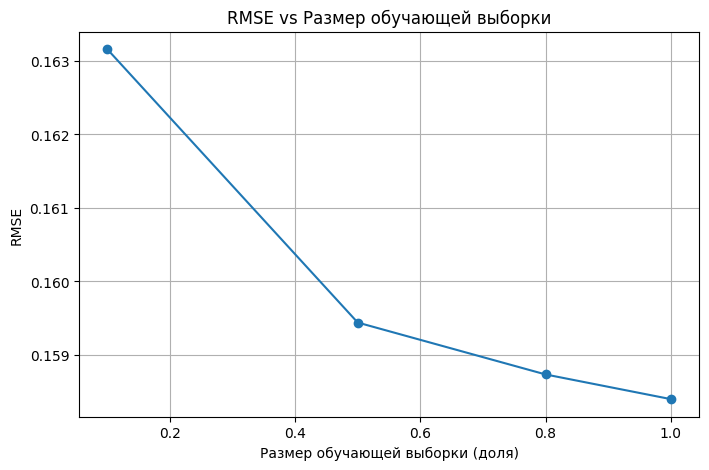

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, rmse_scores, marker='o')
plt.title('RMSE vs Размер обучающей выборки')
plt.xlabel('Размер обучающей выборки (доля)')
plt.ylabel('RMSE')
plt.grid()
plt.show()


# ----------XGBRegressor parallel algorithm----------

In [ ]:
n_jobs_list = [1, 2, 4, 8]
parallel_rmse = []
train_fraction = 0.8  # фиксируем долю обучающей выборки

X_train_part = X_train.sample(frac=train_fraction, random_state=42)
y_train_part = y_train.loc[X_train_part.index]

for n_jobs in n_jobs_list:
    model = xgb.XGBRegressor(
                            n_estimators=1000,        # Кол-во деревьев
                            learning_rate=0.05,       # Скорость обучения (чем меньше, тем точнее, но дольше)
                            max_depth=7,              # Глубина дерева (обычно 6-10)
                            subsample=0.8,            # Доля данных для каждого дерева (bagging)
                            colsample_bytree=0.8,     # Доля признаков для каждого дерева
                            gamma=0,                  # Минимальный прирост для сплита (регулирует переобучение)
                            reg_alpha=0.5,            # L1-регуляризация
                            reg_lambda=1.0,           # L2-регуляризация
                            random_state=42,
                            n_jobs=-1                 # Использовать все ядра
)

    model.fit(X_train_part, y_train_part)
    
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    parallel_rmse.append(rmse)
    
    print(f"n_jobs = {n_jobs}: RMSE = {rmse:.5f}")


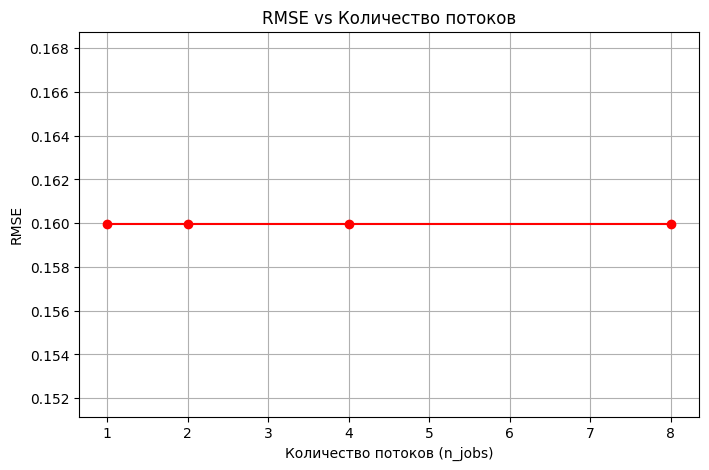

In [10]:
# RMSE от числа ядер
plt.figure(figsize=(8, 5))
plt.plot(n_jobs_list, parallel_rmse, marker='o', color='red')
plt.title('RMSE vs Количество потоков')
plt.xlabel('Количество потоков (n_jobs)')
plt.ylabel('RMSE')
plt.grid()
plt.show()


n_jobs = 1: Train time = 68.98 сек.
n_jobs = 2: Train time = 38.10 сек.
n_jobs = 4: Train time = 23.08 сек.
n_jobs = 8: Train time = 21.26 сек.


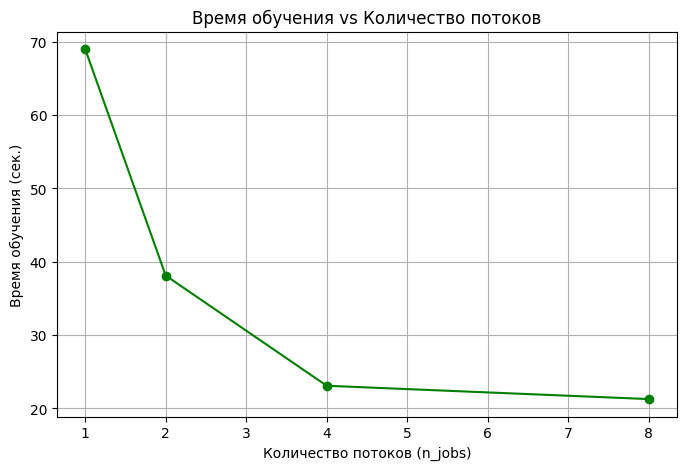

In [11]:
import time

train_times = []

for n_jobs in n_jobs_list:
    model = xgb.XGBRegressor(n_jobs=n_jobs, random_state=42)
    start_time = time.time()
    model.fit(X_train_part, y_train_part)
    train_time = time.time() - start_time
    train_times.append(train_time)
    
    print(f"n_jobs = {n_jobs}: Train time = {train_time:.2f} сек.")

# График времени
plt.figure(figsize=(8, 5))
plt.plot(n_jobs_list, train_times, marker='o', color='green')
plt.title('Время обучения vs Количество потоков')
plt.xlabel('Количество потоков (n_jobs)')
plt.ylabel('Время обучения (сек.)')
plt.grid()
plt.show()
